# Assignment #1: PFL067 Statistical NLP

## Exploring Entropy and Language Modeling

---

### 1. Entropy of a Text

In this experiment, you will determine the conditional entropy of the word distribution in a text given the previous word. To do this, you will first have to compute P(i,j), which is the probability that at any position in the text you will find the word i followed immediately by the word j, and P(j|i), which is the probability that if word i occurs in the text then word j will follow. Given these probabilities, the conditional entropy of the word distribution in a text given the previous word can then be computed as:

$$H(J|I) = -\sum_{i \in I, j \in J} P(i,j) \log_2 P(j|i)$$

The perplexity is then computed simply as

$$P_X(P(J|I)) = 2^{H(J|I)}$$

Compute this conditional entropy and perplexity for `TEXTEN1.txt`. This file has every word on a separate line. (Punctuation is considered a word, as in many other cases.) The i,j above will also span sentence boundaries, where i is the last word of one sentence and j is the first word of the following sentence (but obviously, there will be a fullstop at the end of most sentences).

---

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import collections as c
import math
import random
from numpy.random import RandomState
import matplotlib.pyplot as plt

In [2]:
random.seed(200)
np.random.seed(200)

In [3]:
english = './TEXTEN1.txt'
czech = './TEXTCZ1.txt'

In [4]:
def open_text(filename):
    """Reads a text line by line, applies light preprocessing, and returns a dataframe of each word"""
    with open(filename, encoding='iso-8859-2') as f:
        content = f.readlines()
    
    preprocess = lambda word: word.strip()
#     preprocess = lambda word: word.strip().lower()

    text = pd.DataFrame(content, columns=['words'])
    text.words = text.words.apply(preprocess)
    
    return text

In [5]:
def process_ngrams(text):
    """Generates a list of bigrams and trigrams from a text and inserts it into the dataframe"""
    wordprev = text.words.shift(1).fillna('<s>')
    wordprev2 = wordprev.shift(1).fillna('<ss>')
    
    text['bigrams'] = list(zip(wordprev, text.words))
    text['trigrams'] = list(zip(*[wordprev2, wordprev, text.words]))
    
    return text

In [6]:
process_ngrams(open_text(english))[:5]

,words,bigrams,trigrams
0,WHEN,"(<s>, WHEN)","(<ss>, <s>, WHEN)"
1,on,"(WHEN, on)","(<s>, WHEN, on)"
2,board,"(on, board)","(WHEN, on, board)"
3,H,"(board, H)","(on, board, H)"
4,.,"(H, .)","(board, H, .)"


In [7]:
process_ngrams(open_text(czech))[:5]

,words,bigrams,trigrams
0,V,"(<s>, V)","(<ss>, <s>, V)"
1,.,"(V, .)","(<s>, V, .)"
2,LAŠTŮVKA,"(., LAŠTŮVKA)","(V, ., LAŠTŮVKA)"
3,:,"(LAŠTŮVKA, :)","(., LAŠTŮVKA, :)"
4,AŤ,"(:, AŤ)","(LAŠTŮVKA, :, AŤ)"


In [8]:
def language_model(text):
    """Counts unigrams and bigrams in a dataframe"""
    words = list(text.words) + ['<s>']
    word_counts = c.Counter(words)
    num_words = sum(word_counts.values())
    vocabulary = sorted(list(set(word_counts.keys())))

    bigrams = list(text.bigrams)
    bigram_counts = c.Counter(bigrams)
    num_bigrams = sum(bigram_counts.values())
    bigram_vocabulary = sorted(list(set(bigram_counts.keys())))
    
    unigram_model = words, word_counts, num_words, vocabulary
    bigram_model = bigrams, bigram_counts, num_bigrams, bigram_vocabulary
    
    return unigram_model, bigram_model

In [9]:
def Pword(unigram_model, W='', alpha=0.7):
    """Calculates the probability a word appears in a sentence"""
    _, word_counts, num_words, vocabulary = unigram_model
    return (word_counts[W] + alpha) / (num_words + alpha * len(vocabulary))

In [10]:
def Pbigram(bigram_model, W='', Wprev='', alpha=0.7):
    """Calculates the probability a bigram appears in a sentence"""
    _, bigram_counts, num_bigrams, bigram_vocabulary = bigram_model
    return (bigram_counts[(Wprev, W)] + alpha) / (num_bigrams + alpha * len(bigram_vocabulary))

In [11]:
# P(A|B) = P(A,B) / P(B)
def Pwprev(models, W='', Wprev='', alpha=0.7):
    """Calculates the probability a word W proceeds a word Wprev"""
    unigram_model, bigram_model = models
    return Pbigram(bigram_model, W=W, Wprev=Wprev, alpha=alpha) / Pword(unigram_model, W=Wprev, alpha=alpha)

In [12]:
def entropy(models, bigrams, alpha=0.7):
    """Calculates the entropy from a list of bigrams"""
    _, bigram_model = models
    return - sum(Pbigram(bigram_model, W=W, Wprev=Wprev, alpha=alpha) 
                 * math.log(Pwprev(models, W=W, Wprev=Wprev, alpha=alpha), 2) for Wprev,W in bigrams)

In [13]:
def perplexity(models, bigrams, alpha=0.7):
    """Calculates the perplexity from a list of bigrams"""
    return 2 ** entropy(models, bigrams, alpha=alpha)

In [14]:
def text_stats(text, alpha=1e-5):
    """Given a list of words, this calculates various statistical 
    properties like entropy, number of characters, etc"""
    process_ngrams(text)
    models = language_model(text)
    unigram_model, bigram_model = models
    words, word_counts, num_words, vocabulary = unigram_model
    bigrams, bigram_counts, num_bigrams, bigram_vocabulary = bigram_model
    
    H = entropy(models, bigram_vocabulary, alpha=alpha)
    P = 2 ** H
    vocab_size = len(vocabulary)
    char_count = len([char for word in words for char in word])
    chars_per_word = char_count / num_words
    words_freq_1 = sum(1 for key in word_counts if word_counts[key] == 1)
    most_freq_words = word_counts.most_common()[:10]

    return [H, P, vocab_size, char_count, chars_per_word, words_freq_1, most_freq_words]

In [15]:
text_stats_cols = [
    'entropy', 'perplexity', 'vocab_size', 'char_count', 
    'chars_per_word', 'words_freq_1', 'most_freq_words'
]

In [16]:
def text_stats_lang(filename):
    """Calculates statistics from a file and arranges them in a nicely formatted table"""
    return pd.DataFrame([text_stats(open_text(filename))], columns=text_stats_cols)

In [17]:
text_stats_lang(english)

,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,5.287425,39.054708,9608,972920,4.400382,3812,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."


In [18]:
text_stats_lang(czech)

,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,4.747819,26.868035,42827,1030634,4.633875,26316,"[(,, 13788), (., 12931), (a, 4486), (v, 4043),..."


Next, you will mess up the text and measure how this alters the conditional entropy. For every character in the text, mess it up with a likelihood of 10%. If a character is chosen to be messed up, map it into a randomly chosen character from the set of characters that appear in the text. Since there is some randomness to the outcome of the experiment, run the experiment 10 times, each time measuring the conditional entropy of the resulting text, and give the min, max, and average entropy from these experiments. Be sure to use srand to reset the random number generator seed each time you run it. Also, be sure each time you are messing up the original text, and not a previously messed up text. Do the same experiment for mess up likelihoods of 5%, 1%, .1%, .01%, and .001%.

Next, for every word in the text, mess it up with a likelihood of 10%. If a word is chosen to be messed up, map it into a randomly chosen word from the set of words that appear in the text. Again run the experiment 10 times, each time measuring the conditional entropy of the resulting text, and give the min, max, and average entropy from these experiments. Do the same experiment for mess up likelihoods of 5%, 1%, .1%, .01%, and .001%.

Now do exactly the same for the file `TEXTCZ1.txt`, which contains a similar amount of text in an unknown language (just FYI, that's Czech*)

Tabulate, graph and explain your results. Also try to explain the differences between the two languages. To substantiate your explanations, you might want to tabulate also the basic characteristics of the two texts, such as the word count, number of characters (total, per word), the frequency of the most frequent words, the number of words with frequency 1, etc.

In [19]:
def charset(words):
    """Given a list of words, calculates the set of characters over all words"""
    return sorted(list(set(char for word in words for char in word)))

In [20]:
charset(open_text(english).words)[:10]

['!', '"', '&', "'", '(', ')', ',', '.', '/', '0']

In [21]:
def vocab_list(words):
    """Given a list of words, calculates the set of words (vocabulary)"""
    return sorted(list(set(word for word in words)))

In [22]:
vocab_list(open_text(english).words)[:10]

['"', '&', '&c', '&e', '(', ')', ',', '.', '000', '1']

In [23]:
def perturb_char(word, charset, prob=0.1):
    """Changes each character with given probability to a random character in the charset"""
    return ''.join(np.random.choice(charset) if np.random.random() < prob else char for char in word)

In [24]:
def perturb_word(word, vocabulary, prob=0.1):
    """Changes a word with given probability to a random word in the vocabulary"""
    return np.random.choice(vocabulary) if np.random.random() < prob else word

In [25]:
def perturb(words, charset, vocabulary, prob=0.1):
    """Perturbs a list of words with given probability on the character level and word level"""
    pchars = words.apply(lambda word: perturb_char(word, charset, prob=prob))
    pwords = words.apply(lambda word: perturb_word(word, vocabulary, prob=prob))
    
    return pchars, pwords

In [26]:
def perturb_text(text, seed=200):
    """Perturbs a list of words for a predefined list of probabilties"""
    np.random.seed(seed)
    
    chars, vocab = charset(text.words), vocab_list(text.words)
    text_chars, text_words = pd.DataFrame(), pd.DataFrame()
    
    for prob in [0, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]:
        text_chars[str(prob)], text_words[str(prob)] = perturb(text.words, chars, vocab, prob=prob)
    
    return text_chars, text_words

In [27]:
def all_stats(perturbed_text):
    """Calculates statistics for all perturbed probabilities of a given text 
    and outputs them to two tables (character and word level respectively)"""
    text_chars, text_words = perturbed_text
    
    col_names = ['prob'] + text_stats_cols
    
    char_stats = pd.DataFrame(columns=col_names)
    word_stats = pd.DataFrame(columns=col_names)
    
    # Iterate through all perturbation probabilities and gather statistics
    for col in text_chars:
        stat = text_stats(pd.DataFrame(list(text_chars[col]), columns=['words']))
        char_stats.loc[len(char_stats)] = [float(col)] + stat
    
    for col in text_words:
        stat = text_stats(pd.DataFrame(list(text_words[col]), columns=['words']))
        word_stats.loc[len(word_stats)] = [float(col)] + stat
    
    return char_stats, word_stats

In [28]:
perturbed_en = perturb_text(open_text(english))
perturbed_cz = perturb_text(open_text(czech))

In [29]:
char_stats_en, word_stats_en = all_stats(perturbed_en)
char_stats_cz, word_stats_cz = all_stats(perturbed_cz)

In [30]:
char_stats_en

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,5.287425,39.054708,9608,972920,4.400382,3812,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
1,0.00001,5.287402,39.054109,9616,972920,4.400382,3820,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
2,0.00010,5.287292,39.051132,9707,972920,4.400382,3911,"[(,, 14720), (the, 13294), (of, 9363), (., 564..."
3,0.00100,5.282875,38.931733,10477,972920,4.400382,4683,"[(,, 14705), (the, 13267), (of, 9346), (., 563..."
4,0.01000,5.248710,38.020624,17738,972920,4.400382,11647,"[(,, 14582), (the, 12907), (of, 9156), (., 558..."
5,0.05000,5.053660,33.212617,42418,972920,4.400382,34647,"[(,, 14000), (the, 11443), (of, 8508), (., 537..."
6,0.10000,4.725691,26.459082,64547,972920,4.400382,55328,"[(,, 13251), (the, 9774), (of, 7610), (., 5147..."


In [31]:
word_stats_en

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,5.287425,39.054708,9608,972920,4.400382,3812,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
1,0.00001,5.287412,39.054375,9608,972923,4.400395,3811,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
2,0.00010,5.287473,39.056014,9608,972998,4.400735,3797,"[(,, 14719), (the, 13296), (of, 9367), (., 564..."
3,0.00100,5.289637,39.114640,9604,973692,4.403873,3715,"[(,, 14703), (the, 13280), (of, 9361), (., 563..."
4,0.01000,5.306678,39.579399,9578,979955,4.432200,3035,"[(,, 14588), (the, 13152), (of, 9265), (., 558..."
5,0.05000,5.376210,41.533684,9558,1006274,4.551237,1261,"[(,, 14012), (the, 12679), (of, 8905), (., 538..."
6,0.10000,5.461522,44.063813,9562,1039370,4.700926,449,"[(,, 13217), (the, 11990), (of, 8443), (., 505..."


In [32]:
char_stats_cz

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,4.747819,26.868035,42827,1030634,4.633875,26316,"[(,, 13788), (., 12931), (a, 4486), (v, 4043),..."
1,0.00001,4.747700,26.865823,42836,1030634,4.633875,26325,"[(,, 13788), (., 12930), (a, 4486), (v, 4043),..."
2,0.00010,4.747000,26.852780,42902,1030634,4.633875,26402,"[(,, 13786), (., 12931), (a, 4486), (v, 4043),..."
3,0.00100,4.737882,26.683612,43604,1030634,4.633875,27167,"[(,, 13770), (., 12918), (a, 4479), (v, 4039),..."
4,0.01000,4.656089,25.212885,50056,1030634,4.633875,34396,"[(,, 13654), (., 12803), (a, 4446), (v, 4016),..."
5,0.05000,4.336803,20.207281,73432,1030634,4.633875,60523,"[(,, 13110), (., 12305), (a, 4282), (v, 3876),..."
6,0.10000,4.000147,16.001632,94670,1030634,4.633875,84291,"[(,, 12502), (., 11709), (a, 4054), (v, 3689),..."


In [33]:
word_stats_cz

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,4.747819,26.868035,42827,1030634,4.633875,26316,"[(,, 13788), (., 12931), (a, 4486), (v, 4043),..."
1,0.00001,4.747795,26.867587,42826,1030657,4.633978,26313,"[(,, 13787), (., 12930), (a, 4486), (v, 4043),..."
2,0.00010,4.747871,26.869012,42825,1030679,4.634077,26304,"[(,, 13788), (., 12930), (a, 4486), (v, 4043),..."
3,0.00100,4.747386,26.859968,42798,1031394,4.637292,26156,"[(,, 13777), (., 12921), (a, 4483), (v, 4037),..."
4,0.01000,4.738342,26.692119,42584,1038085,4.667376,24909,"[(,, 13623), (., 12792), (a, 4439), (v, 3991),..."
5,0.05000,4.699295,25.979382,41791,1065252,4.789522,20033,"[(,, 13090), (., 12297), (a, 4258), (v, 3829),..."
6,0.10000,4.637887,24.896768,41166,1100412,4.947606,15648,"[(,, 12472), (., 11636), (a, 4027), (v, 3652),..."


In [52]:
### Configure Plots
plt.rcParams['lines.linewidth'] = 3

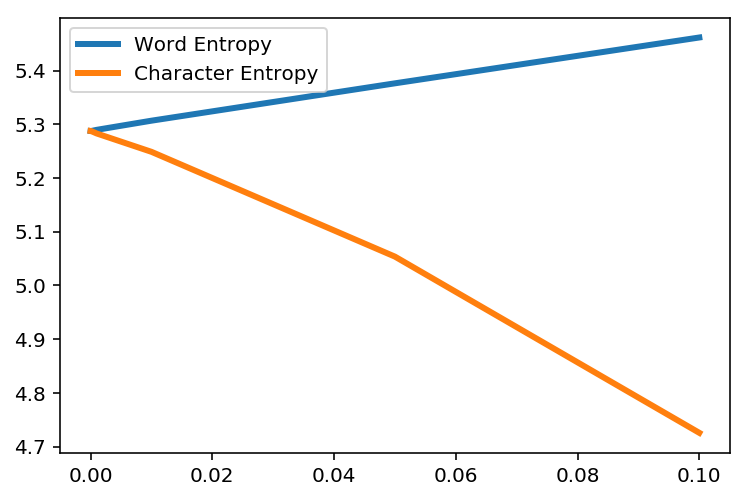

In [53]:
### English
plt.plot(word_stats_en.prob, word_stats_en.entropy, label='Word Entropy')
plt.plot(char_stats_en.prob, char_stats_en.entropy, label='Character Entropy')
plt.legend()

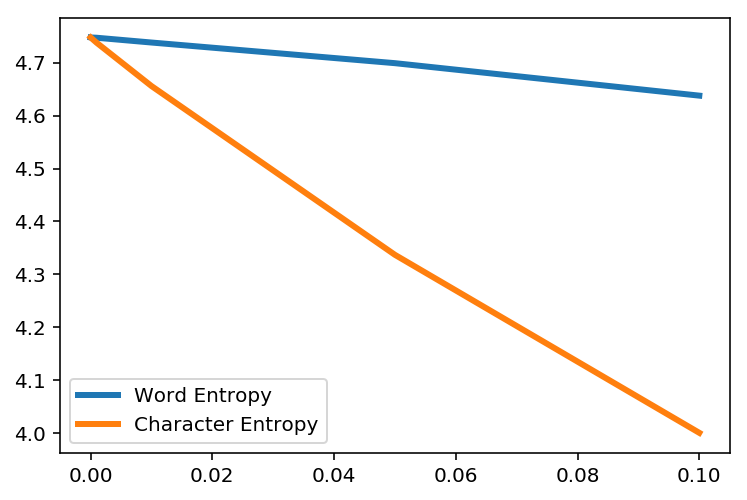

In [54]:
### Czech
plt.plot(word_stats_cz.prob, word_stats_cz.entropy, label='Word Entropy')
plt.plot(char_stats_cz.prob, char_stats_cz.entropy, label='Character Entropy')
plt.legend()